In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Final\ exam

/content/drive/.shortcut-targets-by-id/1ha3ze0UCLYx87PL6z2Jm14BVHB5RXYaH/Final exam


In [ ]:
# !unzip data.zip

In [ ]:
import collections
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

from kaggle_submission import output_submission_csv
from src.config import VOC_CLASSES, COLORS
from src.dataset import VocDetectorDataset
from src.eval_voc import evaluate
from src.predict import predict_image
from src.resnet_yolo import resnet50
from yolo_loss import YoloLoss

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [ ]:
load_network_path = None #'checkpoints/best_detector.pth'
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


In [ ]:
learning_rate = 0.001
num_epochs = 10
batch_size = 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

In [ ]:
file_root_train = 'data/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'data/voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [ ]:
file_root_test = 'data/VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'data/voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


In [ ]:
data = train_dataset[0]

## Set up training tools

In [ ]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [ ]:
import torch.cuda as cuda
print(f"Initial GPU memory allocated: {cuda.memory_allocated() / 1024 ** 2:.2f} MB")

Initial GPU memory allocated: 105.22 MB


In [ ]:
len(data)

4

In [ ]:
data[0].shape

torch.Size([3, 448, 448])

## Train detector

In [ ]:
best_test_loss = np.inf
learning_rate = 1e-3
for epoch in range(num_epochs):
    net.train()

    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))

    total_loss = collections.defaultdict(int)

    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()

        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % (epoch + 1, num_epochs, i + 1, len(train_loader))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)

    # evaluate the network on the test data
    if (epoch + 1) % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data

            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += loss_dict['total_loss'].item()
        test_loss /= len(test_loader)

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'checkpoints/best_detector.pth')

    if (epoch+1) in [5, 10]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'checkpoints/detector.pth')





Starting epoch 1 / 10
Learning Rate for this epoch: 0.001


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/10], Iter [50/209], Loss: total=23.361, reg=3.730, containing_obj=0.342, no_obj=12.458, cls=6.831
Epoch [1/10], Iter [100/209], Loss: total=15.272, reg=3.153, containing_obj=0.443, no_obj=6.454, cls=5.223
Epoch [1/10], Iter [150/209], Loss: total=12.225, reg=2.877, containing_obj=0.513, no_obj=4.407, cls=4.428
Epoch [1/10], Iter [200/209], Loss: total=10.538, reg=2.684, containing_obj=0.558, no_obj=3.367, cls=3.930
Updating best test loss: 5.36113


Starting epoch 2 / 10
Learning Rate for this epoch: 0.001
Epoch [2/10], Iter [50/209], Loss: total=5.195, reg=2.120, containing_obj=0.762, no_obj=0.200, cls=2.114
Epoch [2/10], Iter [100/209], Loss: total=5.080, reg=2.075, containing_obj=0.779, no_obj=0.187, cls=2.039
Epoch [2/10], Iter [150/209], Loss: total=4.982, reg=2.044, containing_obj=0.784, no_obj=0.176, cls=1.979
Epoch [2/10], Iter [200/209], Loss: total=4.885, reg=2.002, containing_obj=0.791, no_obj=0.166, cls=1.926
Updating best test loss: 4.61277


Starting epoch 3 / 10

100%|██████████| 4950/4950 [02:26<00:00, 33.71it/s]


---class aeroplane ap 0.013027396076397892---
---class bicycle ap 0.013847675568743818---
---class bird ap 0.01585465543266055---
---class boat ap 0.0006337135614702154---
---class bottle ap 0.0---
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.01253181336786518---
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.003978779840848806---
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.0007005278648388189---
---class pottedplant ap 0.0---
---class sheep ap 0.0---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0--- (no predictions for this class)
---class tvmonitor ap 0.0016233766233766235---
---map 0.0031098969168100953---
4 [0.013027396076397892, 0.0

100%|██████████| 4950/4950 [02:32<00:00, 32.36it/s]


---class aeroplane ap 0.32056923844615254---
---class bicycle ap 0.2435211351554187---
---class bird ap 0.18185957517535845---
---class boat ap 0.03393958373466047---
---class bottle ap 0.043320040141635444---
---class bus ap 0.26519315828221335---
---class car ap 0.42462684579760457---
---class cat ap 0.35503977073326537---
---class chair ap 0.1475917422183522---
---class cow ap 0.2570230844034143---
---class diningtable ap 0.0344722429673886---
---class dog ap 0.32348663651654075---
---class horse ap 0.4883230163984534---
---class motorbike ap 0.31404181979732165---
---class person ap 0.3400576454240272---
---class pottedplant ap 0.07812458594426365---
---class sheep ap 0.2181838181089392---
---class sofa ap 0.07362075264888564---
---class train ap 0.3895220295077555---
---class tvmonitor ap 0.2669920739008517---
---map 0.23997543976512511---
9 [0.32056923844615254, 0.2435211351554187, 0.18185957517535845, 0.03393958373466047, 0.043320040141635444, 0.26519315828221335, 0.424626845797

In [ ]:

network_paths = ['checkpoints/detector_epoch_%d.pth' % epoch for epoch in [5, 10]]+['checkpoints/detector.pth']
for load_network_path in network_paths:
    print('Loading saved network from {}'.format(load_network_path))
    net_loaded =  resnet50().to(device)
    net_loaded.load_state_dict(torch.load(load_network_path))
    evaluate(net_loaded, test_dataset_file=annotation_file_test, img_root=file_root_test)

Loading saved network from checkpoints/detector_epoch_5.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:29<00:00, 33.06it/s]


---class aeroplane ap 0.013027396076397892---
---class bicycle ap 0.013847675568743818---
---class bird ap 0.01585465543266055---
---class boat ap 0.0006337135614702154---
---class bottle ap 0.0---
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.01253181336786518---
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.003978779840848806---
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.0007005278648388189---
---class pottedplant ap 0.0---
---class sheep ap 0.0---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0--- (no predictions for this class)
---class tvmonitor ap 0.0016233766233766235---
---map 0.0031098969168100953---
Loading saved network from c

100%|██████████| 4950/4950 [02:40<00:00, 30.83it/s]


---class aeroplane ap 0.32056923844615254---
---class bicycle ap 0.2435211351554187---
---class bird ap 0.18185957517535845---
---class boat ap 0.03393958373466047---
---class bottle ap 0.043320040141635444---
---class bus ap 0.26519315828221335---
---class car ap 0.42462684579760457---
---class cat ap 0.35503977073326537---
---class chair ap 0.1475917422183522---
---class cow ap 0.2570230844034143---
---class diningtable ap 0.0344722429673886---
---class dog ap 0.32348663651654075---
---class horse ap 0.4883230163984534---
---class motorbike ap 0.31404181979732165---
---class person ap 0.3400576454240272---
---class pottedplant ap 0.07812458594426365---
---class sheep ap 0.2181838181089392---
---class sofa ap 0.07362075264888564---
---class train ap 0.3895220295077555---
---class tvmonitor ap 0.2669920739008517---
---map 0.23997543976512511---
Loading saved network from checkpoints/detector.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:39<00:00, 31.04it/s]


---class aeroplane ap 0.32056923844615254---
---class bicycle ap 0.2435211351554187---
---class bird ap 0.18185957517535845---
---class boat ap 0.03393958373466047---
---class bottle ap 0.043320040141635444---
---class bus ap 0.26519315828221335---
---class car ap 0.42462684579760457---
---class cat ap 0.35503977073326537---
---class chair ap 0.1475917422183522---
---class cow ap 0.2570230844034143---
---class diningtable ap 0.0344722429673886---
---class dog ap 0.32348663651654075---
---class horse ap 0.4883230163984534---
---class motorbike ap 0.31404181979732165---
---class person ap 0.3400576454240272---
---class pottedplant ap 0.07812458594426365---
---class sheep ap 0.2181838181089392---
---class sofa ap 0.07362075264888564---
---class train ap 0.3895220295077555---
---class tvmonitor ap 0.2669920739008517---
---map 0.23997543976512511---


# View example predictions

predicting...


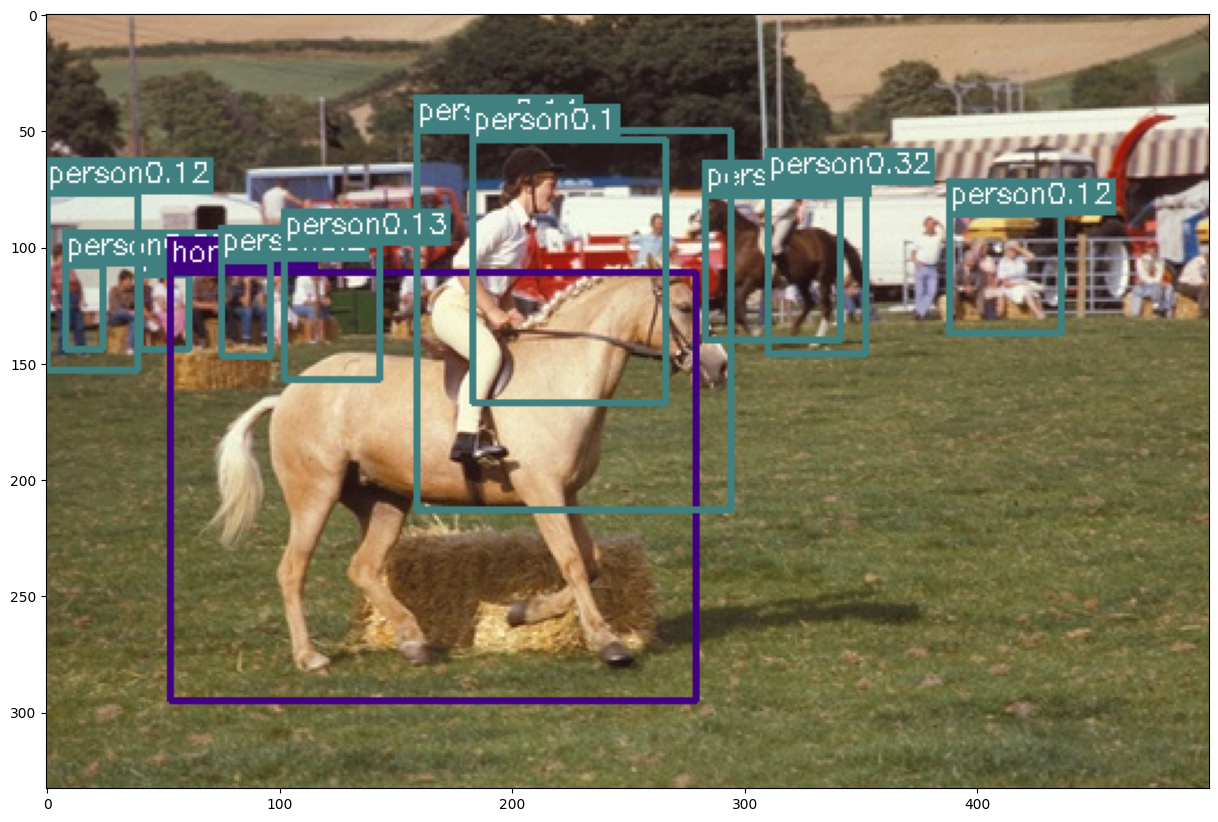

In [ ]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

predicting...


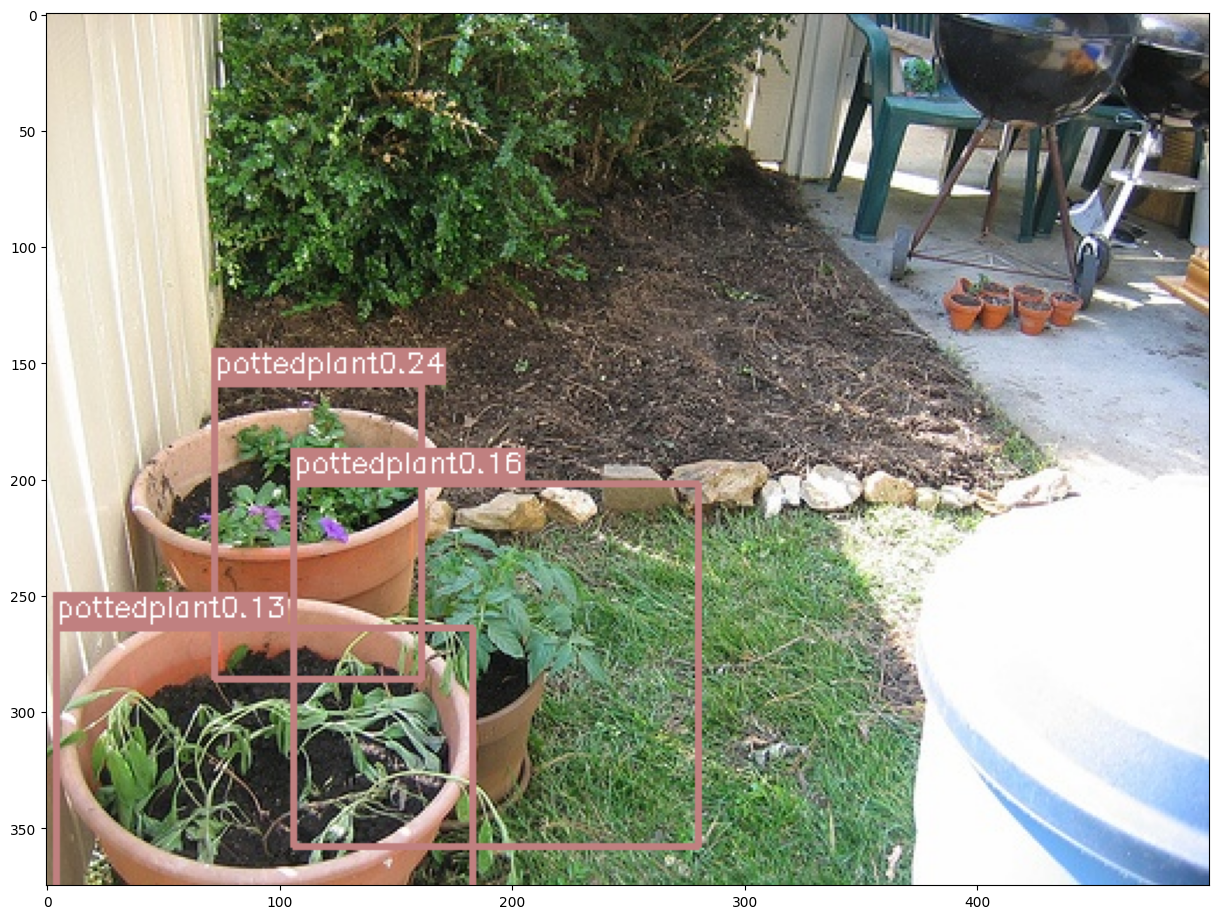

In [22]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


predicting...


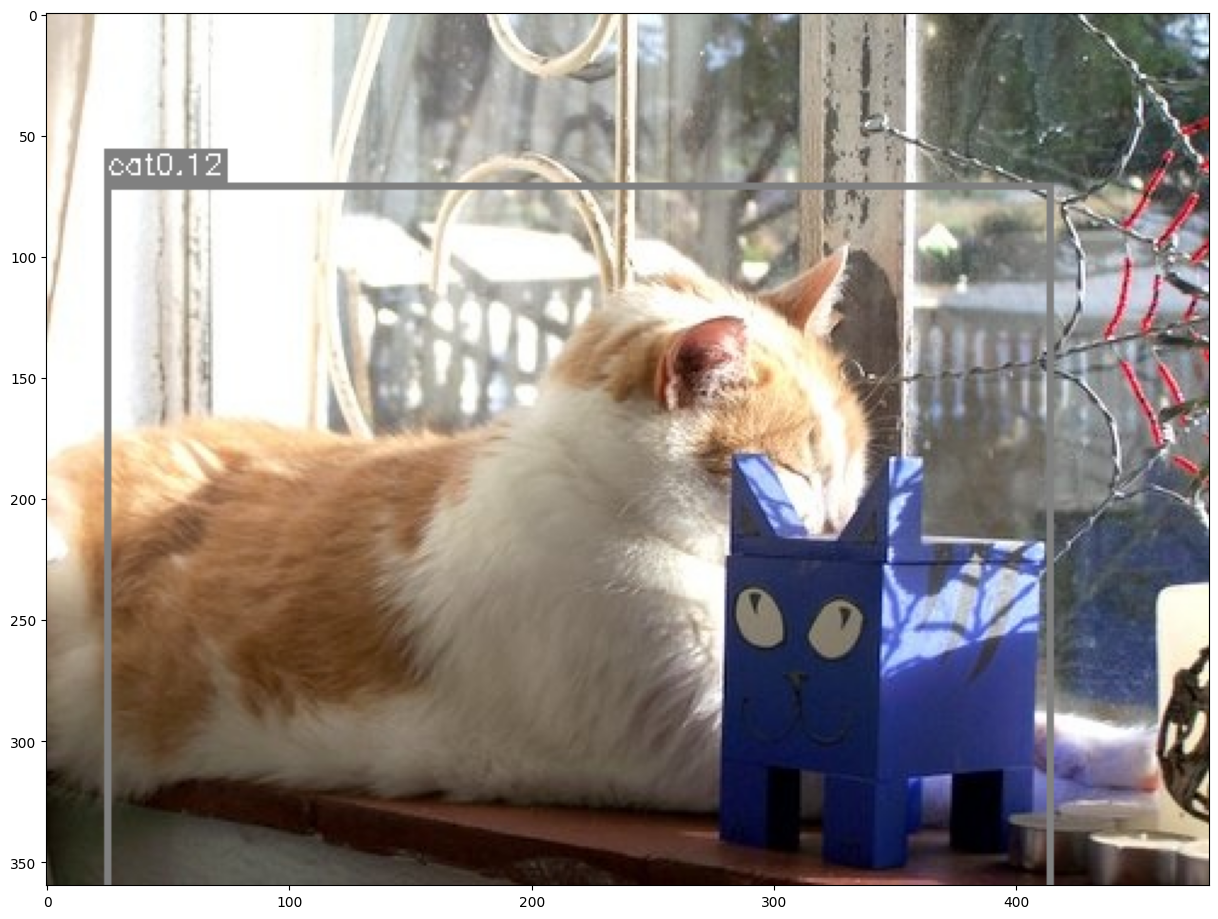

In [23]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


predicting...


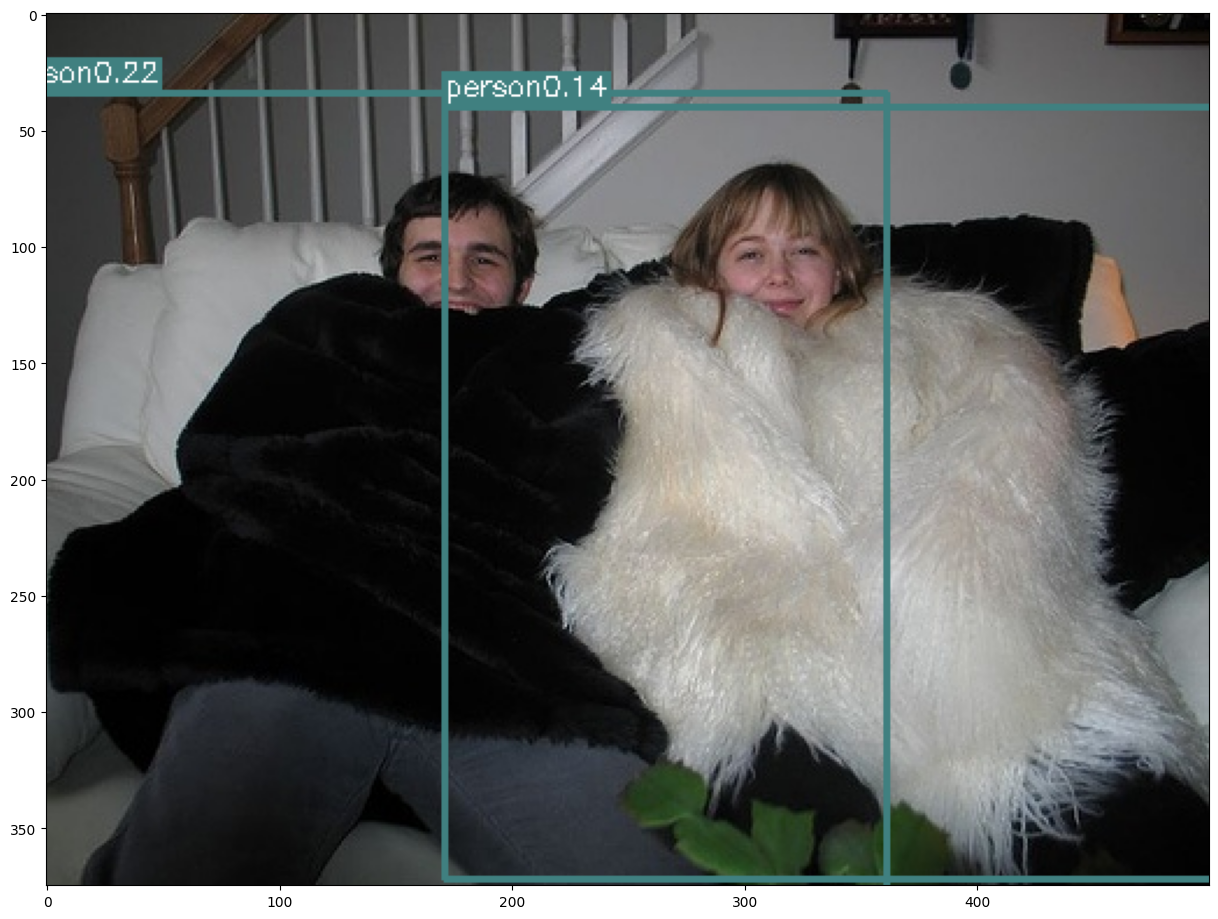

In [24]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


In [ ]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:40<00:00, 30.86it/s]


---class aeroplane ap 0.32056923844615254---
---class bicycle ap 0.2435211351554187---
---class bird ap 0.18185957517535845---
---class boat ap 0.03393958373466047---
---class bottle ap 0.043320040141635444---
---class bus ap 0.26519315828221335---
---class car ap 0.42462684579760457---
---class cat ap 0.35503977073326537---
---class chair ap 0.1475917422183522---
---class cow ap 0.2570230844034143---
---class diningtable ap 0.0344722429673886---
---class dog ap 0.32348663651654075---
---class horse ap 0.4883230163984534---
---class motorbike ap 0.31404181979732165---
---class person ap 0.3400576454240272---
---class pottedplant ap 0.07812458594426365---
---class sheep ap 0.2181838181089392---
---class sofa ap 0.07362075264888564---
---class train ap 0.3895220295077555---
---class tvmonitor ap 0.2669920739008517---
---map 0.23997543976512511---


### Cell added to get intermediate mAP values for students

In [ ]:
network_paths = [f'checkpoints/detector_epoch_{epoch}.pth' for epoch in [5, 10]] + ['checkpoints/detector.pth']
for load_network_path in network_paths:
    print(f'Loading saved network from {load_network_path}')
    net_loaded = resnet50().to(device)
    net_loaded.load_state_dict(torch.load(load_network_path))
    evaluate(net_loaded, test_dataset_file=annotation_file_test, img_root=file_root_test)

Loading saved network from checkpoints/detector_epoch_5.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:35<00:00, 31.88it/s]


---class aeroplane ap 0.013027396076397892---
---class bicycle ap 0.013847675568743818---
---class bird ap 0.01585465543266055---
---class boat ap 0.0006337135614702154---
---class bottle ap 0.0---
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.01253181336786518---
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.003978779840848806---
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.0007005278648388189---
---class pottedplant ap 0.0---
---class sheep ap 0.0---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0--- (no predictions for this class)
---class tvmonitor ap 0.0016233766233766235---
---map 0.0031098969168100953---
Loading saved network from c

100%|██████████| 4950/4950 [02:40<00:00, 30.91it/s]


---class aeroplane ap 0.32056923844615254---
---class bicycle ap 0.2435211351554187---
---class bird ap 0.18185957517535845---
---class boat ap 0.03393958373466047---
---class bottle ap 0.043320040141635444---
---class bus ap 0.26519315828221335---
---class car ap 0.42462684579760457---
---class cat ap 0.35503977073326537---
---class chair ap 0.1475917422183522---
---class cow ap 0.2570230844034143---
---class diningtable ap 0.0344722429673886---
---class dog ap 0.32348663651654075---
---class horse ap 0.4883230163984534---
---class motorbike ap 0.31404181979732165---
---class person ap 0.3400576454240272---
---class pottedplant ap 0.07812458594426365---
---class sheep ap 0.2181838181089392---
---class sofa ap 0.07362075264888564---
---class train ap 0.3895220295077555---
---class tvmonitor ap 0.2669920739008517---
---map 0.23997543976512511---
Loading saved network from checkpoints/detector.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:41<00:00, 30.62it/s]


---class aeroplane ap 0.32056923844615254---
---class bicycle ap 0.2435211351554187---
---class bird ap 0.18185957517535845---
---class boat ap 0.03393958373466047---
---class bottle ap 0.043320040141635444---
---class bus ap 0.26519315828221335---
---class car ap 0.42462684579760457---
---class cat ap 0.35503977073326537---
---class chair ap 0.1475917422183522---
---class cow ap 0.2570230844034143---
---class diningtable ap 0.0344722429673886---
---class dog ap 0.32348663651654075---
---class horse ap 0.4883230163984534---
---class motorbike ap 0.31404181979732165---
---class person ap 0.3400576454240272---
---class pottedplant ap 0.07812458594426365---
---class sheep ap 0.2181838181089392---
---class sofa ap 0.07362075264888564---
---class train ap 0.3895220295077555---
---class tvmonitor ap 0.2669920739008517---
---map 0.23997543976512511---


In [ ]:
output_submission_csv('our_new_solution.csv', test_aps)